In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

sns.set_style('whitegrid')

In [19]:
from numpy.random import normal, gamma

class NormalTwoGroupDiff:
    def __init__(self, δ0, τ20):
        self.δ0 = δ0
        self.τ20 = τ20
        self.λ0 = 1/τ20
    
    def sample_prior(self, size=1):
        return normal(loc=self.δ0, scale=np.sqrt(self.τ20), size=size)
    
    def sample_posterior(self, n1, X1_mean, n2, X2_mean, μ, σ20, size=1):
        γ = 1/σ20
        λn = self.λ0 + (n1+n2) * γ
        τ2n = 1/λn

        δn = τ2n * (self.λ0*self.δ0 + γ * (n1 * (X1_mean-μ) + n2 * (μ-X2_mean)))
        return normal(loc=δn, scale=np.sqrt(τ2n), size=size)

class NormalTwoGroupMean:
    def __init__(self, μ0, τ20):
        self.μ0 = μ0
        self.τ20 = τ20
        self.λ0 = 1/τ20
    
    def sample_prior(self, size=1):
        return normal(loc=self.μ0, scale=np.sqrt(self.τ20), size=size)
    
    def sample_posterior(self, n1, X1_mean, n2, X2_mean, δ, σ20, size=1):
        n = n1 + n2
        γ = 1/σ20
        λn = self.λ0 + n * γ
        τ2n = 1/λn

        μn = τ2n * (self.λ0*self.μ0 + γ * (n1 * (X1_mean-δ) + n2 * (X2_mean+δ)))
        return normal(loc=μn, scale=np.sqrt(τ2n), size=size)

class GammaTwoGroupPrec:
    def __init__(self, ν0, σ20):
        self.ν0 = ν0
        self.σ20 = σ20
    
    def sample_prior(self, size=1):
        return gamma(shape=self.ν0/2, scale=2/(self.ν0 * self.σ20), size=size)
    
    def sample_posterior(self, n1, X1_sd, X1_mean, n2, X2_sd, X2_mean, μ, δ, size=1):
        n = n1 + n2
        νn = self.ν0 + n

        X1_squared = n1 * (X1_sd**2 + X1_mean*82 + (μ + δ)**2 - 2*(μ + δ)*X1_mean)
        X2_squared = n2 * (X2_sd**2 + X2_mean*82 + (μ - δ)**2 - 2*(μ - δ)*X2_mean)
        σ2n = 1/νn * (self.ν0*self.σ20 + X1_squared + X2_squared) 

        return gamma(shape=νn/2, scale=2/(νn*σ2n), size=size)

In [88]:
from itertools import product

deltas = [-4, -2, 0, 2, 4]
tau2s = [10, 50, 100, 500]

n_epoch = 10000
burn_in = 1000

n1, n2 = 16, 16
X1_mean, X1_sd = 75.2, 7.3
X2_mean, X2_sd = 77.5, 8.1
μ_rv = NormalTwoGroupMean(75, 100)
γ_rv = GammaTwoGroupPrec(1, 100)

data = {}
for δ0, τ20 in list(product(deltas, tau2s)):
    δ_rv = NormalTwoGroupDiff(δ0, τ20)

    samples = []

    μ = μ_rv.sample_prior()
    δ = δ_rv.sample_prior()
    for epoch in range(n_epoch+burn_in):
        γ = γ_rv.sample_posterior(n1, X1_sd, X1_mean, n2, X2_sd, X2_mean, μ, δ)
        μ = μ_rv.sample_posterior(n1, X1_mean, n2, X2_mean, δ, 1/γ)
        δ = δ_rv.sample_posterior(n1, X1_mean, n2, X2_mean, μ, 1/γ)

        if epoch < burn_in:
            continue
        else:
            samples.append((μ[0], δ[0], 1/γ[0], μ_rv.sample_prior()[0], δ_rv.sample_prior()[0]))
    
    df = pd.DataFrame(samples, columns=['mu', 'delta', 'sigma2', 'mu0', 'delta0'])

    data[(δ0, τ20)] = {
        'P[delta < 0|Y]': (df.delta < 0).mean(),
        '95% CI LB': df.delta.quantile([0.025, 0.975]).values[0],
        '95% CI UB': df.delta.quantile([0.025, 0.975]).values[1],
        'Post Theta Corr': np.corrcoef(df.mu+df.delta, df.mu-df.delta)[0, 1],
        'Prior Theta Corr': np.corrcoef(df.mu0+df.delta0, df.mu0-df.delta0)[0, 1],
    }

In [93]:
d = np.round(pd.DataFrame(data).T, 2)
d.index.names = ('δ0', 'τ20')

In [96]:
d

P[delta < 0|Y]  95% CI LB  95% CI UB  Post Theta Corr  \
δ0 τ20                                                          
-4 10             0.88      -7.83       2.01             0.40   
   50             0.70      -8.74       4.85             0.08   
   100            0.66      -9.03       5.85             0.01   
   500            0.62      -9.42       6.75            -0.06   
-2 10             0.75      -6.53       3.20             0.40   
   50             0.66      -8.39       5.56             0.07   
   100            0.63      -8.82       6.23             0.00   
   500            0.62      -9.15       6.86            -0.07   
 0 10             0.57      -5.27       4.50             0.40   
   50             0.59      -7.78       6.05             0.07   
   100            0.60      -8.47       6.48             0.00   
   500            0.61      -8.80       7.00            -0.05   
 2 10             0.38      -3.96       5.68             0.40   
   50             0.54      -7.32       6.68             0.05   
   100            0.58      -8.09       6.73            -0.01   
   500            0.60      -9.10       6.64            -0.05   
 4 10             0.21      -2.85       6.92             0.41   
   50             0.49      -6.93       7.24             0.06   
   100            0.54      -7.81       7.20            -0.00   
   500            0.59      -8.89       7.05            -0.07   

        Prior Theta Corr  
δ0 τ20                    
-4 10               0.82  
   50               0.33  
   100              0.01  
   500             -0.67  
-2 10               0.82  
   50               0.33  
   100             -0.01  
   500             -0.67  
 0 10               0.82  
   50               0.33  
   100              0.00  
   500             -0.67  
 2 10               0.82  
   50               0.34  
   100              0.00  
   500             -0.67  
 4 10               0.82  
   50               0.33  
   100             -0.01  
   500             -0.67

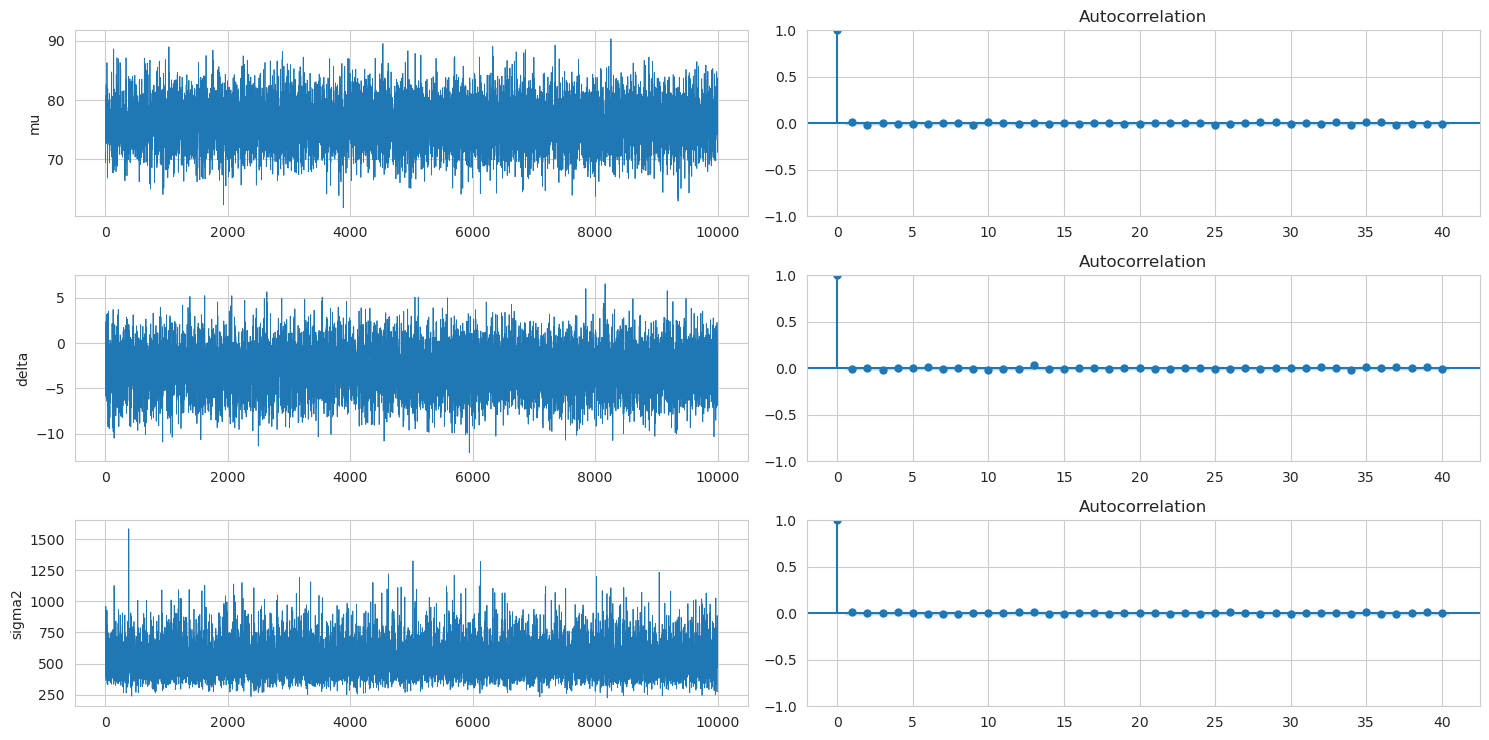

In [37]:
k_variables = 3
fig, ax = plt.subplots(k_variables, 2, figsize=(15, 2.5*k_variables))

for i, (col_name, sr) in enumerate(df.iteritems()):
    sr.plot(linewidth=0.6, label=col_name, ax=ax[i, 0])
    sm.graphics.tsa.plot_acf(sr, ax=ax[i, 1])
    ax[i, 0].set_ylabel(col_name)

fig.tight_layout()
fig.show()